#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
# Robustness Parameter
robustness_parameter = .2

# Reconfiguration Parameters
N_Reconfigurations = 20
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = .3

# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

# Depth & Height of first Reconfiguration
Initial_Depth = 20
Initial_Height = 10

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 20
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**3
Train_step_proportion = .7


# Unknown Function
def unknown_f(x):
    return .1*x + .1*(x**2) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) #+ x % 1

### Run External/Auxiliary Notebooks

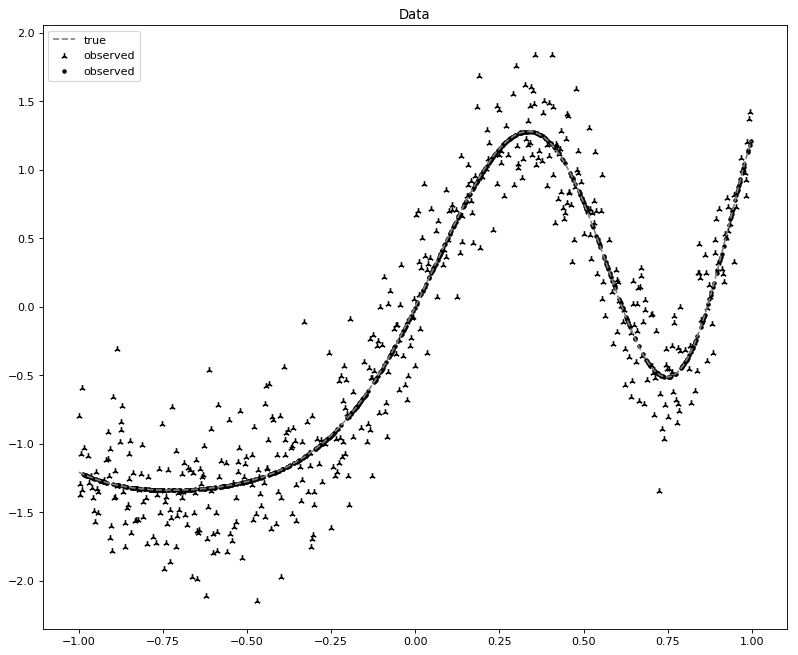

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=200,
                                                height=100,
                                                depth=10,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 [==============================] - 0s 5ms/step - loss: 0.8833 - mse: 1.0345 - mae: 0.8833 - mape: 157.6371
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 0.8536 - mse: 0.9948 - mae: 0.8536 - mape: 254.7918
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 0.8227 - mse: 0.9231 - mae: 0.8227 - mape: 195.0922
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 0.6001 - mse: 0.5348 - mae: 0.6001 - mape: 205.8687
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4622 - mse: 0.3334 - mae: 0.4622 - mape: 226.6578
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 0.5015 - mse: 0.3874 - mae: 0.5015 - mape: 268.7228
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 0.4882 - mse: 0.3737 - mae: 0.4882 - mape: 167.1686
Epoch 8/200
16/16 [==============================] - 0s 3ms/step - loss

16/16 [==============================] - 0s 2ms/step - loss: 0.2850 - mse: 0.1336 - mae: 0.2850 - mape: 100.7078
Epoch 66/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2780 - mse: 0.1257 - mae: 0.2780 - mape: 120.1784
Epoch 67/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2716 - mse: 0.1170 - mae: 0.2716 - mape: 141.3438
Epoch 68/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2656 - mse: 0.1112 - mae: 0.2656 - mape: 145.6572
Epoch 69/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3025 - mse: 0.1457 - mae: 0.3025 - mape: 150.3351
Epoch 70/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2984 - mse: 0.1416 - mae: 0.2984 - mape: 136.7852
Epoch 71/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2860 - mse: 0.1312 - mae: 0.2860 - mape: 125.9035
Epoch 72/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3069 - mse: 0.1552 - mae: 0.3069 - mape: 129.2636
Epoch

16/16 [==============================] - 0s 3ms/step - loss: 0.2748 - mse: 0.1212 - mae: 0.2748 - mape: 133.3961
Epoch 130/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2907 - mse: 0.1358 - mae: 0.2907 - mape: 149.1814
Epoch 131/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2985 - mse: 0.1429 - mae: 0.2985 - mape: 129.4706
Epoch 132/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2930 - mse: 0.1367 - mae: 0.2930 - mape: 140.7660
Epoch 133/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2735 - mse: 0.1204 - mae: 0.2735 - mape: 133.7156
Epoch 134/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2638 - mse: 0.1127 - mae: 0.2638 - mape: 130.3789
Epoch 135/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2692 - mse: 0.1143 - mae: 0.2692 - mape: 135.5148
Epoch 136/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2840 - mse: 0.1238 - mae: 0.2840 - mape: 115.860

16/16 [==============================] - 0s 3ms/step - loss: 0.2856 - mse: 0.1312 - mae: 0.2856 - mape: 140.7902
Epoch 194/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2833 - mse: 0.1258 - mae: 0.2833 - mape: 130.1674
Epoch 195/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2761 - mse: 0.1181 - mae: 0.2761 - mape: 128.1604
Epoch 196/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2902 - mse: 0.1417 - mae: 0.2902 - mape: 152.3557
Epoch 197/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3056 - mse: 0.1550 - mae: 0.3056 - mape: 136.2083
Epoch 198/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2708 - mse: 0.1157 - mae: 0.2708 - mape: 135.0733
Epoch 199/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2722 - mse: 0.1194 - mae: 0.2722 - mape: 122.4781
Epoch 200/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2705 - mse: 0.1142 - mae: 0.2705 - mape: 131.458

## Get base regression model for NEU

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 - 0s - loss: 69.6646 - mse: 0.5139 - mae: 0.4400 - mape: 81.5598
Epoch 2/200
16/16 - 0s - loss: 68.7258 - mse: 0.4165 - mae: 0.3748 - mape: 105.0124
Epoch 3/200
16/16 - 0s - loss: 67.5835 - mse: 0.3315 - mae: 0.2932 - mape: 91.6259
Epoch 4/200
16/16 - 0s - loss: 67.2147 - mse: 0.2242 - mae: 0.2781 - mape: 103.6268
Epoch 5/200
16/16 - 0s - loss: 66.9903 - mse: 0.2037 - mae: 0.2627 - mape: 119.2859
Epoch 6/200
16/16 - 0s - loss: 66.8457 - mse: 0.1899 - mae: 0.2525 - mape: 130.0928
Epoch 7/200
16/16 - 0s - loss: 66.8432 - mse: 0.1960 - mae: 0.2515 - mape: 107.2168
Epoch 8/200
16/16 - 0s - loss: 66.8746 - mse: 0.2006 - mae: 0.2533 - mape: 63.9423
Epoch 9/200
16/16 - 0s - loss: 66.9034 - mse: 0.2028 - mae: 0.2553 - mape: 75.3191
Epoch 10/200
16/16 - 0s - loss: 66.5682 - mse: 0.1680 - mae: 0.2335 - mape: 101.3906
Epoch 11/200
16/16 - 0s - loss: 66.4978 - mse: 0.1644 - mae: 0.2274 - mape: 146.6092
Epoch 12/200
16/16 - 0s 

Epoch 98/200
16/16 - 0s - loss: 65.4106 - mse: 0.0728 - mae: 0.1521 - mape: 64.3204
Epoch 99/200
16/16 - 0s - loss: 65.3387 - mse: 0.0683 - mae: 0.1470 - mape: 53.2220
Epoch 100/200
16/16 - 0s - loss: 65.2338 - mse: 0.0614 - mae: 0.1399 - mape: 56.8420
Epoch 101/200
16/16 - 0s - loss: 65.2925 - mse: 0.0680 - mae: 0.1440 - mape: 62.4225
Epoch 102/200
16/16 - 0s - loss: 65.6503 - mse: 0.0944 - mae: 0.1695 - mape: 77.8135
Epoch 103/200
16/16 - 0s - loss: 65.3580 - mse: 0.0712 - mae: 0.1484 - mape: 69.1443
Epoch 104/200
16/16 - 0s - loss: 65.1908 - mse: 0.0596 - mae: 0.1363 - mape: 68.5343
Epoch 105/200
16/16 - 0s - loss: 65.2455 - mse: 0.0616 - mae: 0.1405 - mape: 60.6070
Epoch 106/200
16/16 - 0s - loss: 65.1677 - mse: 0.0577 - mae: 0.1349 - mape: 66.0112
Epoch 107/200
16/16 - 0s - loss: 65.1209 - mse: 0.0553 - mae: 0.1313 - mape: 65.1312
Epoch 108/200
16/16 - 0s - loss: 65.1686 - mse: 0.0578 - mae: 0.1350 - mape: 73.4101
Epoch 109/200
16/16 - 0s - loss: 65.2408 - mse: 0.0612 - mae: 0.140

Epoch 195/200
16/16 - 0s - loss: 65.3676 - mse: 0.0752 - mae: 0.1484 - mape: 54.4278
Epoch 196/200
16/16 - 0s - loss: 65.1518 - mse: 0.0565 - mae: 0.1337 - mape: 64.3762
Epoch 197/200
16/16 - 0s - loss: 65.2737 - mse: 0.0653 - mae: 0.1418 - mape: 55.6809
Epoch 198/200
16/16 - 0s - loss: 65.2353 - mse: 0.0621 - mae: 0.1398 - mape: 63.4094
Epoch 199/200
16/16 - 0s - loss: 65.1703 - mse: 0.0574 - mae: 0.1352 - mape: 61.1100
Epoch 200/200
16/16 - 0s - loss: 65.1310 - mse: 0.0552 - mae: 0.1323 - mape: 72.9697
Base Regressor-Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/assets
Base Regressor-Model: Saved


### Generate Plots - Visualization

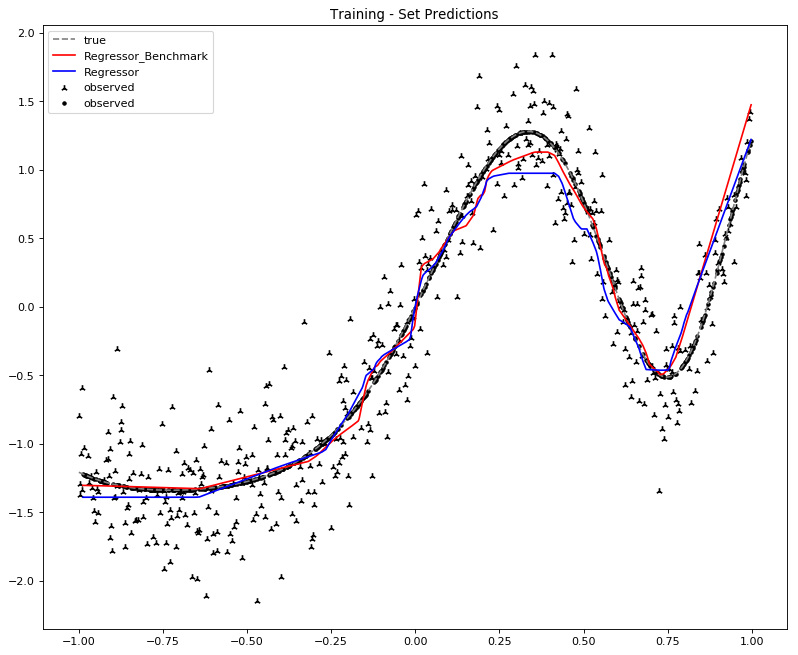

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
0.6892433823648727
0.05
0.7631171293125241
0.1
2.821644291754955
0.15
1.991948061622515
0.2
3.008309406870614
0.25
3.0005558562998913
0.3
0.5056475722556102
0.35
0.29010397074336003
0.4
0.7528414885915704
0.45
3.521273212812264
0.5
0.757301258204454
0.55
3.1294946760171576
0.6
1.7698675300635562
0.65
3.204880777325571
0.7
1.3329972545962157
0.75
2.718672808557904
0.8
0.8852511225237394
0.85
1.9215500765978177
0.9
0.5318210504681187
0.95
0.8986644525216314
1.0
Complete: Pre-Training Readout Map on Input x Output Space!
Saving Pre-Trained Readout on Input x Output Space!
INFO:tensorflow:Assets written to: ./outputs/models/NEU/Greedy_Initializations/assets
(Full-)Model does not exist: Training.
Epoch 1/600
16/16 [==============================] - 0s 16ms/step - loss: 34.7918 - mse: 0.3306 - mae: 0.4541
Epoch 2/600
16/16 [==============================] - 0s 16ms/step - loss: 33.7084 - mse: 0.1481 - mae: 0.3025
Epoch 3/600
16/16 [================

16/16 [==============================] - 0s 18ms/step - loss: 33.4084 - mse: 0.1087 - mae: 0.2595
Epoch 69/600
16/16 [==============================] - 0s 18ms/step - loss: 33.4174 - mse: 0.1117 - mae: 0.2609
Epoch 70/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3774 - mse: 0.1038 - mae: 0.2554
Epoch 71/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3826 - mse: 0.1066 - mae: 0.2564
Epoch 72/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3701 - mse: 0.1039 - mae: 0.2535
Epoch 73/600
16/16 [==============================] - 0s 18ms/step - loss: 33.3794 - mse: 0.1060 - mae: 0.2548
Epoch 74/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4418 - mse: 0.1115 - mae: 0.2644
Epoch 75/600
16/16 [==============================] - 0s 20ms/step - loss: 33.4942 - mse: 0.1196 - mae: 0.2716
Epoch 76/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3963 - mse: 0.1090 - mae: 0.2574
Epoch 77/600
1

16/16 [==============================] - 0s 17ms/step - loss: 33.3832 - mse: 0.1060 - mae: 0.2566
Epoch 142/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4053 - mse: 0.1093 - mae: 0.2588
Epoch 143/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3870 - mse: 0.1073 - mae: 0.2569
Epoch 144/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4037 - mse: 0.1089 - mae: 0.2595
Epoch 145/600
16/16 [==============================] - 0s 17ms/step - loss: 33.5428 - mse: 0.1246 - mae: 0.2790
Epoch 146/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3855 - mse: 0.1092 - mae: 0.2565
Epoch 147/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3832 - mse: 0.1068 - mae: 0.2569
Epoch 148/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4095 - mse: 0.1073 - mae: 0.2596
Epoch 149/600
16/16 [==============================] - 0s 16ms/step - loss: 33.4093 - mse: 0.1077 - mae: 0.2599
Epoch 

16/16 [==============================] - 0s 19ms/step - loss: 33.3383 - mse: 0.1013 - mae: 0.2488
Epoch 215/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4218 - mse: 0.1101 - mae: 0.2617
Epoch 216/600
16/16 [==============================] - 0s 18ms/step - loss: 33.4049 - mse: 0.1086 - mae: 0.2593
Epoch 217/600
16/16 [==============================] - 0s 19ms/step - loss: 33.3878 - mse: 0.1065 - mae: 0.2561
Epoch 218/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3884 - mse: 0.1047 - mae: 0.2563
Epoch 219/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4016 - mse: 0.1074 - mae: 0.2586
Epoch 220/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3092 - mse: 0.0985 - mae: 0.2453
Epoch 221/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3605 - mse: 0.1024 - mae: 0.2523
Epoch 222/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4102 - mse: 0.1072 - mae: 0.2595
Epoch 

16/16 [==============================] - 0s 17ms/step - loss: 33.3649 - mse: 0.1033 - mae: 0.2533
Epoch 288/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3398 - mse: 0.0998 - mae: 0.2497
Epoch 289/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3786 - mse: 0.1027 - mae: 0.2554
Epoch 290/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3207 - mse: 0.0999 - mae: 0.2469
Epoch 291/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4152 - mse: 0.1075 - mae: 0.2611
Epoch 292/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3480 - mse: 0.1034 - mae: 0.2509
Epoch 293/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3479 - mse: 0.1028 - mae: 0.2504
Epoch 294/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3948 - mse: 0.1076 - mae: 0.2578
Epoch 295/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3609 - mse: 0.1043 - mae: 0.2528
Epoch 

16/16 [==============================] - 0s 18ms/step - loss: 33.3779 - mse: 0.1063 - mae: 0.2546
Epoch 361/600
16/16 [==============================] - 0s 19ms/step - loss: 33.3929 - mse: 0.1083 - mae: 0.2574
Epoch 362/600
16/16 [==============================] - 0s 21ms/step - loss: 33.3711 - mse: 0.1042 - mae: 0.2544
Epoch 363/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3390 - mse: 0.1032 - mae: 0.2497
Epoch 364/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3581 - mse: 0.1013 - mae: 0.2520
Epoch 365/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3345 - mse: 0.1007 - mae: 0.2482
Epoch 366/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3478 - mse: 0.1047 - mae: 0.2509
Epoch 367/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3597 - mse: 0.1039 - mae: 0.2524
Epoch 368/600
16/16 [==============================] - 0s 21ms/step - loss: 33.3920 - mse: 0.1048 - mae: 0.2567
Epoch 

16/16 [==============================] - 0s 17ms/step - loss: 33.3362 - mse: 0.1017 - mae: 0.2482
Epoch 434/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3325 - mse: 0.1000 - mae: 0.2487
Epoch 435/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3434 - mse: 0.1033 - mae: 0.2500
Epoch 436/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3943 - mse: 0.1074 - mae: 0.2571
Epoch 437/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3742 - mse: 0.1058 - mae: 0.2544
Epoch 438/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3528 - mse: 0.1021 - mae: 0.2514
Epoch 439/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3465 - mse: 0.1017 - mae: 0.2509
Epoch 440/600
16/16 [==============================] - 0s 18ms/step - loss: 33.3512 - mse: 0.1023 - mae: 0.2515
Epoch 441/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3327 - mse: 0.1014 - mae: 0.2487
Epoch 

16/16 [==============================] - 0s 19ms/step - loss: 33.3464 - mse: 0.1020 - mae: 0.2502
Epoch 507/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3425 - mse: 0.1010 - mae: 0.2498
Epoch 508/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3380 - mse: 0.1009 - mae: 0.2497
Epoch 509/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3830 - mse: 0.1050 - mae: 0.2565
Epoch 510/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3442 - mse: 0.1004 - mae: 0.2497
Epoch 511/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3433 - mse: 0.1027 - mae: 0.2500
Epoch 512/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3975 - mse: 0.1083 - mae: 0.2584
Epoch 513/600
16/16 [==============================] - 0s 18ms/step - loss: 33.3414 - mse: 0.1002 - mae: 0.2500
Epoch 514/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3396 - mse: 0.1010 - mae: 0.2499
Epoch 

16/16 [==============================] - 0s 17ms/step - loss: 33.3291 - mse: 0.0988 - mae: 0.2473
Epoch 580/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3564 - mse: 0.1031 - mae: 0.2519
Epoch 581/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3525 - mse: 0.1011 - mae: 0.2512
Epoch 582/600
16/16 [==============================] - 0s 16ms/step - loss: 33.3460 - mse: 0.1002 - mae: 0.2504
Epoch 583/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3316 - mse: 0.1004 - mae: 0.2487
Epoch 584/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3291 - mse: 0.0985 - mae: 0.2475
Epoch 585/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3622 - mse: 0.1046 - mae: 0.2530
Epoch 586/600
16/16 [==============================] - 0s 17ms/step - loss: 33.4267 - mse: 0.1103 - mae: 0.2621
Epoch 587/600
16/16 [==============================] - 0s 17ms/step - loss: 33.3452 - mse: 0.1024 - mae: 0.2497
Epoch 

### Generate Plots - Visualization

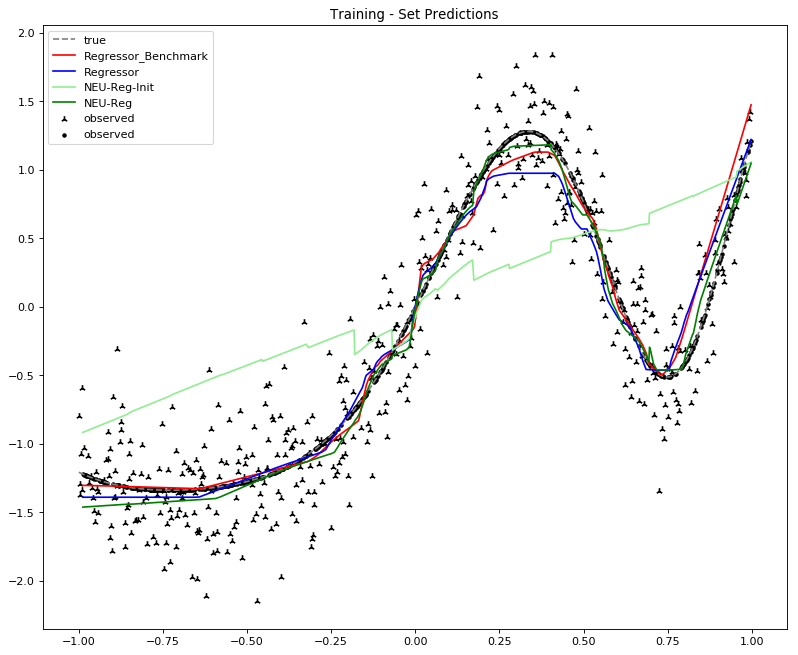

In [9]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

---
---
---

# Benchmark Models

In [10]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Model does not exist: Training.
Epoch 1/200
16/16 - 0s - loss: 0.4408 - mse: 0.5156 - mae: 0.4408 - mape: 81.6105
Epoch 2/200
16/16 - 0s - loss: 0.4270 - mse: 0.4970 - mae: 0.4270 - mape: 127.1042
Epoch 3/200
16/16 - 0s - loss: 0.4252 - mse: 0.4879 - mae: 0.4252 - mape: 113.2104
Epoch 4/200
16/16 - 0s - loss: 0.4249 - mse: 0.4929 - mae: 0.4249 - mape: 124.6728
Epoch 5/200
16/16 - 0s - loss: 0.4253 - mse: 0.4842 - mae: 0.4253 - mape: 109.2461
Epoch 6/200
16/16 - 0s - loss: 0.4249 - mse: 0.4949 - mae: 0.4249 - mape: 117.3718
Epoch 7/200
16/16 - 0s - loss: 0.4280 - mse: 0.4871 - mae: 0.4280 - mape: 105.4618
Epoch 8/200
16/16 - 0s - loss: 0.4259 - mse: 0.5012 - mae: 0.4259 - mape: 133.8765
Epoch 9/200
16/16 - 0s - loss: 0.4237 - mse: 0.4898 - mae: 0.4237 - mape: 120.6422
Epoch 10/200
16/16 - 0s - loss: 0.4244 - mse: 0.4856 - mae: 0.4244 - mape: 112.5189
Epoch 11/200
16/16 - 0s - loss: 0.4180 - mse: 0.4807 - mae: 0.4180 - mape: 119.8021
Epoch 12/200
16/16 - 0s - loss: 0.4017 - mse:

16/16 - 0s - loss: 0.1648 - mse: 0.0862 - mae: 0.1648 - mape: 57.5409
Epoch 100/200
16/16 - 0s - loss: 0.1540 - mse: 0.0773 - mae: 0.1540 - mape: 50.5548
Epoch 101/200
16/16 - 0s - loss: 0.1548 - mse: 0.0795 - mae: 0.1548 - mape: 50.4480
Epoch 102/200
16/16 - 0s - loss: 0.1601 - mse: 0.0835 - mae: 0.1601 - mape: 44.1471
Epoch 103/200
16/16 - 0s - loss: 0.1630 - mse: 0.0865 - mae: 0.1630 - mape: 58.9270
Epoch 104/200
16/16 - 0s - loss: 0.1515 - mse: 0.0770 - mae: 0.1515 - mape: 56.9900
Epoch 105/200
16/16 - 0s - loss: 0.1590 - mse: 0.0830 - mae: 0.1590 - mape: 67.4172
Epoch 106/200
16/16 - 0s - loss: 0.1547 - mse: 0.0808 - mae: 0.1547 - mape: 64.3085
Epoch 107/200
16/16 - 0s - loss: 0.1538 - mse: 0.0800 - mae: 0.1538 - mape: 53.5374
Epoch 108/200
16/16 - 0s - loss: 0.1587 - mse: 0.0820 - mae: 0.1587 - mape: 57.9097
Epoch 109/200
16/16 - 0s - loss: 0.1609 - mse: 0.0839 - mae: 0.1609 - mape: 46.3938
Epoch 110/200
16/16 - 0s - loss: 0.1531 - mse: 0.0757 - mae: 0.1531 - mape: 60.9010
Epoch 

Epoch 197/200
16/16 - 0s - loss: 0.1496 - mse: 0.0752 - mae: 0.1496 - mape: 72.3993
Epoch 198/200
16/16 - 0s - loss: 0.1544 - mse: 0.0770 - mae: 0.1544 - mape: 53.6329
Epoch 199/200
16/16 - 0s - loss: 0.1521 - mse: 0.0743 - mae: 0.1521 - mape: 61.4455
Epoch 200/200
16/16 - 0s - loss: 0.1477 - mse: 0.0737 - mae: 0.1477 - mape: 61.2516
Epoch 1/600
16/16 [==============================] - 0s 3ms/step - loss: 1.6156 - mse: 1.6156 - mae: 1.1355
Epoch 2/600
16/16 [==============================] - 0s 3ms/step - loss: 1.5636 - mse: 1.5636 - mae: 1.1174
Epoch 3/600
16/16 [==============================] - 0s 3ms/step - loss: 1.5160 - mse: 1.5160 - mae: 1.1007
Epoch 4/600
16/16 [==============================] - 0s 3ms/step - loss: 1.4722 - mse: 1.4722 - mae: 1.0847
Epoch 5/600
16/16 [==============================] - 0s 3ms/step - loss: 1.4317 - mse: 1.4317 - mae: 1.0697
Epoch 6/600
16/16 [==============================] - 0s 3ms/step - loss: 1.3938 - mse: 1.3938 - mae: 1.0549
Epoch 7/600
16/1

16/16 [==============================] - 0s 3ms/step - loss: 0.7947 - mse: 0.7947 - mae: 0.7341
Epoch 74/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7928 - mse: 0.7928 - mae: 0.7327
Epoch 75/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7909 - mse: 0.7909 - mae: 0.7312
Epoch 76/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7890 - mse: 0.7890 - mae: 0.7297
Epoch 77/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7871 - mse: 0.7871 - mae: 0.7282
Epoch 78/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7853 - mse: 0.7853 - mae: 0.7267
Epoch 79/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7835 - mse: 0.7835 - mae: 0.7253
Epoch 80/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7817 - mse: 0.7817 - mae: 0.7239
Epoch 81/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7800 - mse: 0.7800 - mae: 0.7224
Epoch 82/600
16/16 [============

16/16 [==============================] - 0s 3ms/step - loss: 0.7131 - mse: 0.7131 - mae: 0.6663
Epoch 148/600
16/16 [==============================] - 0s 5ms/step - loss: 0.7126 - mse: 0.7126 - mae: 0.6659
Epoch 149/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7122 - mse: 0.7122 - mae: 0.6656
Epoch 150/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7117 - mse: 0.7117 - mae: 0.6653
Epoch 151/600
16/16 [==============================] - 0s 4ms/step - loss: 0.7113 - mse: 0.7113 - mae: 0.6650
Epoch 152/600
16/16 [==============================] - 0s 4ms/step - loss: 0.7108 - mse: 0.7108 - mae: 0.6647
Epoch 153/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7104 - mse: 0.7104 - mae: 0.6644
Epoch 154/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7099 - mse: 0.7099 - mae: 0.6641
Epoch 155/600
16/16 [==============================] - 0s 3ms/step - loss: 0.7095 - mse: 0.7095 - mae: 0.6638
Epoch 156/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6894 - mse: 0.6894 - mae: 0.6511
Epoch 222/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6892 - mse: 0.6892 - mae: 0.6510
Epoch 223/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6890 - mse: 0.6890 - mae: 0.6509
Epoch 224/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6888 - mse: 0.6888 - mae: 0.6508
Epoch 225/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6886 - mse: 0.6886 - mae: 0.6507
Epoch 226/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6883 - mse: 0.6883 - mae: 0.6506
Epoch 227/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6881 - mse: 0.6881 - mae: 0.6505
Epoch 228/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6879 - mse: 0.6879 - mae: 0.6504
Epoch 229/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6877 - mse: 0.6877 - mae: 0.6503
Epoch 230/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6734 - mse: 0.6734 - mae: 0.6453
Epoch 296/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6732 - mse: 0.6732 - mae: 0.6452
Epoch 297/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6730 - mse: 0.6730 - mae: 0.6451
Epoch 298/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6727 - mse: 0.6727 - mae: 0.6451
Epoch 299/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6725 - mse: 0.6725 - mae: 0.6449
Epoch 300/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6723 - mse: 0.6723 - mae: 0.6449
Epoch 301/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6720 - mse: 0.6720 - mae: 0.6448
Epoch 302/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6718 - mse: 0.6718 - mae: 0.6447
Epoch 303/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6716 - mse: 0.6716 - mae: 0.6446
Epoch 304/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6555 - mse: 0.6555 - mae: 0.6382
Epoch 370/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6552 - mse: 0.6552 - mae: 0.6380
Epoch 371/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6549 - mse: 0.6549 - mae: 0.6379
Epoch 372/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6547 - mse: 0.6547 - mae: 0.6378
Epoch 373/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6544 - mse: 0.6544 - mae: 0.6377
Epoch 374/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - mse: 0.6541 - mae: 0.6376
Epoch 375/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6539 - mse: 0.6539 - mae: 0.6375
Epoch 376/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6536 - mse: 0.6536 - mae: 0.6374
Epoch 377/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6533 - mse: 0.6533 - mae: 0.6372
Epoch 378/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6329 - mse: 0.6329 - mae: 0.6293
Epoch 444/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6326 - mse: 0.6326 - mae: 0.6292
Epoch 445/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - mse: 0.6322 - mae: 0.6291
Epoch 446/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6319 - mse: 0.6319 - mae: 0.6289
Epoch 447/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6315 - mse: 0.6315 - mae: 0.6289
Epoch 448/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6311 - mse: 0.6311 - mae: 0.6286
Epoch 449/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6308 - mse: 0.6308 - mae: 0.6285
Epoch 450/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6304 - mse: 0.6304 - mae: 0.6284
Epoch 451/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6301 - mse: 0.6301 - mae: 0.6282
Epoch 452/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.6023 - mse: 0.6023 - mae: 0.6167
Epoch 518/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6018 - mse: 0.6018 - mae: 0.6165
Epoch 519/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6013 - mse: 0.6013 - mae: 0.6163
Epoch 520/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6008 - mse: 0.6008 - mae: 0.6161
Epoch 521/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6003 - mse: 0.6003 - mae: 0.6158
Epoch 522/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5998 - mse: 0.5998 - mae: 0.6156
Epoch 523/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5993 - mse: 0.5993 - mae: 0.6154
Epoch 524/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5988 - mse: 0.5988 - mae: 0.6152
Epoch 525/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5982 - mse: 0.5982 - mae: 0.6150
Epoch 526/600
16/16 [===

16/16 [==============================] - 0s 4ms/step - loss: 0.5572 - mse: 0.5572 - mae: 0.5969
Epoch 592/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5564 - mse: 0.5564 - mae: 0.5965
Epoch 593/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5556 - mse: 0.5556 - mae: 0.5961
Epoch 594/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5548 - mse: 0.5548 - mae: 0.5958
Epoch 595/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5540 - mse: 0.5540 - mae: 0.5954
Epoch 596/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5532 - mse: 0.5532 - mae: 0.5950
Epoch 597/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5524 - mse: 0.5524 - mae: 0.5947
Epoch 598/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5516 - mse: 0.5516 - mae: 0.5944
Epoch 599/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5508 - mse: 0.5508 - mae: 0.5940
Epoch 600/600
16/16 [===

In [11]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Model does not exist: Training.
Epoch 1/600
16/16 [==============================] - 0s 3ms/step - loss: 2.2764 - mse: 2.2764 - mae: 1.2620
Epoch 2/600
16/16 [==============================] - 0s 2ms/step - loss: 1.6847 - mse: 1.6847 - mae: 1.1045
Epoch 3/600
16/16 [==============================] - 0s 4ms/step - loss: 1.4650 - mse: 1.4650 - mae: 1.0329
Epoch 4/600
16/16 [==============================] - 0s 3ms/step - loss: 1.3460 - mse: 1.3460 - mae: 0.9908
Epoch 5/600
16/16 [==============================] - 0s 3ms/step - loss: 1.2704 - mse: 1.2704 - mae: 0.9620
Epoch 6/600
16/16 [==============================] - 0s 2ms/step - loss: 1.2169 - mse: 1.2169 - mae: 0.9433
Epoch 7/600
16/16 [==============================] - 0s 2ms/step - loss: 1.1764 - mse: 1.1764 - mae: 0.9284
Epoch 8/600
16/16 [==============================] - 0s 2ms/step - loss: 1.1445 - mse: 1.1445 - mae: 0.9164
Epoch 9/600
16/16 [==============================] - 0s 2ms/step - loss: 1.1187 - mse: 1.1187 - 

16/16 [==============================] - 0s 3ms/step - loss: 0.8332 - mse: 0.8332 - mae: 0.7749
Epoch 76/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8320 - mse: 0.8320 - mae: 0.7742
Epoch 77/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8309 - mse: 0.8309 - mae: 0.7734
Epoch 78/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8298 - mse: 0.8298 - mae: 0.7727
Epoch 79/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8287 - mse: 0.8287 - mae: 0.7719
Epoch 80/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8276 - mse: 0.8276 - mae: 0.7712
Epoch 81/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8265 - mse: 0.8265 - mae: 0.7704
Epoch 82/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8254 - mse: 0.8254 - mae: 0.7697
Epoch 83/600
16/16 [==============================] - 0s 2ms/step - loss: 0.8243 - mse: 0.8243 - mae: 0.7690
Epoch 84/600
16/16 [============

16/16 [==============================] - 0s 2ms/step - loss: 0.7676 - mse: 0.7676 - mae: 0.7292
Epoch 150/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7669 - mse: 0.7669 - mae: 0.7288
Epoch 151/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7662 - mse: 0.7662 - mae: 0.7283
Epoch 152/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7655 - mse: 0.7655 - mae: 0.7278
Epoch 153/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7649 - mse: 0.7649 - mae: 0.7274
Epoch 154/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7642 - mse: 0.7642 - mae: 0.7269
Epoch 155/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7635 - mse: 0.7635 - mae: 0.7265
Epoch 156/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7628 - mse: 0.7628 - mae: 0.7260
Epoch 157/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7621 - mse: 0.7621 - mae: 0.7256
Epoch 158/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.7230 - mse: 0.7230 - mae: 0.7022
Epoch 224/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7225 - mse: 0.7225 - mae: 0.7019
Epoch 225/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7220 - mse: 0.7220 - mae: 0.7017
Epoch 226/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7215 - mse: 0.7215 - mae: 0.7014
Epoch 227/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7210 - mse: 0.7210 - mae: 0.7011
Epoch 228/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7205 - mse: 0.7205 - mae: 0.7009
Epoch 229/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7200 - mse: 0.7200 - mae: 0.7006
Epoch 230/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7195 - mse: 0.7195 - mae: 0.7004
Epoch 231/600
16/16 [==============================] - 0s 2ms/step - loss: 0.7190 - mse: 0.7190 - mae: 0.7002
Epoch 232/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.6891 - mse: 0.6891 - mae: 0.6866
Epoch 298/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6886 - mse: 0.6886 - mae: 0.6864
Epoch 299/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6881 - mse: 0.6881 - mae: 0.6862
Epoch 300/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6877 - mse: 0.6877 - mae: 0.6860
Epoch 301/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6872 - mse: 0.6872 - mae: 0.6858
Epoch 302/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6867 - mse: 0.6867 - mae: 0.6856
Epoch 303/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6863 - mse: 0.6863 - mae: 0.6854
Epoch 304/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6858 - mse: 0.6858 - mae: 0.6852
Epoch 305/600
16/16 [==============================] - 0s 2ms/step - loss: 0.6853 - mse: 0.6853 - mae: 0.6850
Epoch 306/600
16/16 [===

16/16 [==============================] - 0s 4ms/step - loss: 0.6483 - mse: 0.6483 - mae: 0.6680
Epoch 372/600
16/16 [==============================] - 0s 4ms/step - loss: 0.6477 - mse: 0.6477 - mae: 0.6676
Epoch 373/600
16/16 [==============================] - 0s 4ms/step - loss: 0.6470 - mse: 0.6470 - mae: 0.6675
Epoch 374/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6463 - mse: 0.6463 - mae: 0.6670
Epoch 375/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - mse: 0.6456 - mae: 0.6668
Epoch 376/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6450 - mse: 0.6450 - mae: 0.6665
Epoch 377/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6443 - mse: 0.6443 - mae: 0.6661
Epoch 378/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6436 - mse: 0.6436 - mae: 0.6658
Epoch 379/600
16/16 [==============================] - 0s 3ms/step - loss: 0.6429 - mse: 0.6429 - mae: 0.6655
Epoch 380/600
16/16 [===

16/16 [==============================] - 0s 3ms/step - loss: 0.5872 - mse: 0.5872 - mae: 0.6391
Epoch 446/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5862 - mse: 0.5862 - mae: 0.6386
Epoch 447/600
16/16 [==============================] - 0s 3ms/step - loss: 0.5852 - mse: 0.5852 - mae: 0.6382
Epoch 448/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5842 - mse: 0.5842 - mae: 0.6376
Epoch 449/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5832 - mse: 0.5832 - mae: 0.6372
Epoch 450/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5821 - mse: 0.5821 - mae: 0.6366
Epoch 451/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5811 - mse: 0.5811 - mae: 0.6360
Epoch 452/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5800 - mse: 0.5800 - mae: 0.6357
Epoch 453/600
16/16 [==============================] - 0s 2ms/step - loss: 0.5790 - mse: 0.5790 - mae: 0.6351
Epoch 454/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.4805 - mse: 0.4805 - mae: 0.5816
Epoch 520/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4784 - mse: 0.4784 - mae: 0.5805
Epoch 521/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4762 - mse: 0.4762 - mae: 0.5792
Epoch 522/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4740 - mse: 0.4740 - mae: 0.5778
Epoch 523/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4718 - mse: 0.4718 - mae: 0.5765
Epoch 524/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4695 - mse: 0.4695 - mae: 0.5752
Epoch 525/600
16/16 [==============================] - 0s 3ms/step - loss: 0.4671 - mse: 0.4671 - mae: 0.5738
Epoch 526/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4648 - mse: 0.4648 - mae: 0.5724
Epoch 527/600
16/16 [==============================] - 0s 2ms/step - loss: 0.4625 - mse: 0.4625 - mae: 0.5711
Epoch 528/600
16/16 [===

16/16 [==============================] - 0s 2ms/step - loss: 0.2432 - mse: 0.2432 - mae: 0.4049
Epoch 594/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2401 - mse: 0.2401 - mae: 0.4016
Epoch 595/600
16/16 [==============================] - 0s 3ms/step - loss: 0.2370 - mse: 0.2370 - mae: 0.3987
Epoch 596/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2340 - mse: 0.2340 - mae: 0.3957
Epoch 597/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2311 - mse: 0.2311 - mae: 0.3926
Epoch 598/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2283 - mse: 0.2283 - mae: 0.3895
Epoch 599/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2256 - mse: 0.2256 - mae: 0.3867
Epoch 600/600
16/16 [==============================] - 0s 2ms/step - loss: 0.2229 - mse: 0.2229 - mae: 0.3840
Ed-Nets Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/assets
Ed-Nets Model: 

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [12]:
# Quantile Losses 
#-----------------#
Vanilla = np.array([np.mean(np.abs(predictions_OLS_Benchmark  - data_y)),
                   np.min(np.abs(predictions_OLS_Benchmark - data_y)),
                   np.max(np.abs(predictions_OLS_Benchmark  - data_y)),
                   np.mean(np.power(predictions_OLS_Benchmark  - data_y,2)),
                   Robust_MSE_numpy(predictions_OLS_Benchmark,data_y)])

NEU = np.array([np.mean(np.abs(NEU_OLS_prediction  - data_y)),
 np.min(np.abs(NEU_OLS_prediction  - data_y)),
 np.max(np.abs(NEU_OLS_prediction  - data_y)),
 np.mean(np.power(NEU_OLS_prediction  - data_y,2)),
               Robust_MSE_numpy(NEU_OLS_prediction,data_y)])


NEU_Gld = np.array([np.mean(np.abs(Deep_GLd_prediction  - data_y)),
                   np.min(np.abs(Deep_GLd_prediction  - data_y)),
                   np.max(np.abs(Deep_GLd_prediction  - data_y)),
                   np.mean(np.power(Deep_GLd_prediction  - data_y,2)),
                   Robust_MSE_numpy(Deep_GLd_prediction,data_y)])

NEU_Ed = np.array([np.mean(np.abs(Deep_Ed_prediction- data_y)),
                  np.min(np.abs(Deep_Ed_prediction - data_y)),
                  np.max(np.abs(Deep_Ed_prediction - data_y)),
                  np.mean(np.power(Deep_Ed_prediction - data_y,2)),
                  Robust_MSE_numpy(Deep_Ed_prediction,data_y)])



# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla, 
                        'NEU': NEU,
                        'NEU_GLd': NEU_Gld,
                        'NEU_Ed':NEU_Ed},index={'MAE','MinE','MaxE','MSE','rMSE'})

Results = pd.DataFrame.transpose(Results)

Test results.

In [13]:
# Quantile Losses 
#-----------------#
Vanilla = np.array([np.mean(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.min(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.max(np.abs(predictions_OLS_Benchmark_test  - data_y_test)),
                   np.mean(np.power(predictions_OLS_Benchmark_test  - data_y_test,2)),
                   Robust_MSE_numpy(predictions_OLS_Benchmark_test,data_y_test)])

NEU = np.array([np.mean(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.min(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.max(np.abs(NEU_OLS_prediction_test  - data_y_test)),
 np.mean(np.power(NEU_OLS_prediction_test  - data_y_test,2)),
               Robust_MSE_numpy(NEU_OLS_prediction_test,data_y_test)])

NEU_Gld = np.array([np.mean(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.min(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.max(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                   np.mean(np.power(Deep_GLd_prediction_test  - data_y_test,2)),
                   Robust_MSE_numpy(Deep_GLd_prediction_test,data_y_test)])

NEU_Ed = np.array([np.mean(np.abs(Deep_Ed_prediction_test- data_y_test)),
                  np.min(np.abs(Deep_Ed_prediction_test - data_y_test)),
                  np.max(np.abs(Deep_Ed_prediction_test - data_y_test)),
                  np.mean(np.power(Deep_Ed_prediction_test - data_y_test,2)),
                  Robust_MSE_numpy(Deep_Ed_prediction_test,data_y_test)])



# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla, 
                             'NEU': NEU,
                        'NEU_GLd': NEU_Gld,
                        'NEU_Ed':NEU_Ed},index={'MAE','MinE','MaxE','MSE','rMSE'})

Results_test = pd.DataFrame.transpose(Results_test)

# Visualize Predictions

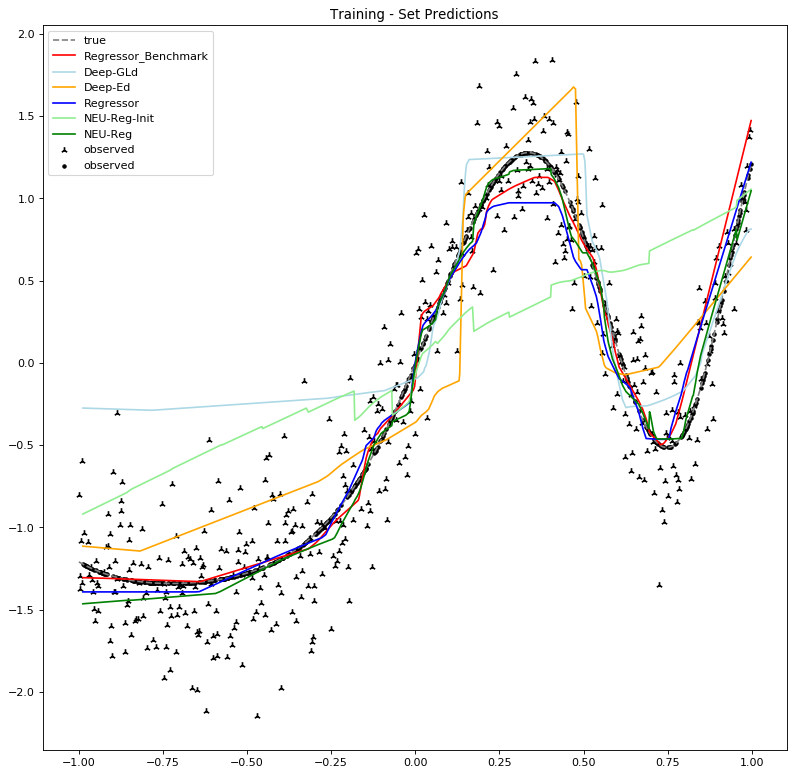

In [14]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

 ---

# Report Results

In [21]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])
Results

Train Results:
             rMSE      MaxE       MSE       MAE      MinE
Vanilla  0.260713  0.001021  1.027042  0.108908  0.264861
NEU      0.250660  0.000608  1.140549  0.101053  0.254541
NEU_GLd  0.593356  0.000030  1.903687  0.549564  0.613444
NEU_Ed   0.382287  0.001072  1.339922  0.221406  0.389928


In [23]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Test Results:
             rMSE      MaxE       MSE       MAE      MinE
Vanilla  0.090801  0.000055  0.393004  0.018063  0.091793
NEU      0.077304  0.000829  0.240837  0.008978  0.077605
NEU_GLd  0.484831  0.000415  1.064979  0.401083  0.501573
NEU_Ed   0.293292  0.001437  0.777232  0.112927  0.296000


#### The END

---